In [1]:
import sqlalchemy
print(sqlalchemy.__version__)

2.0.40


In [2]:
# Directly use sqlite3 and pandas (works with any SQLAlchemy version)
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create a connection to the database
conn = sqlite3.connect('fx_trading.db')

# Test the connection with a simple query
df = pd.read_sql_query("SELECT * FROM fx_rates LIMIT 5", conn)
display(df)

,date,pair,close,open,high,low,volume
0,2024-03-27 22:27:13.553289,EUR/USD,1.080000,1.080453,1.080077,1.079354,1.152070e+06
1,2024-03-28 22:27:13.553289,EUR/USD,1.072293,1.071995,1.072518,1.071163,4.138003e+06
2,2024-03-29 22:27:13.553289,EUR/USD,1.075696,1.074409,1.077451,1.074247,2.237407e+06
3,2024-03-30 22:27:13.553289,EUR/USD,1.080803,1.081080,1.080887,1.080097,2.247468e+06
4,2024-03-31 22:27:13.553289,EUR/USD,1.079037,1.078179,1.079886,1.078934,1.338515e+06


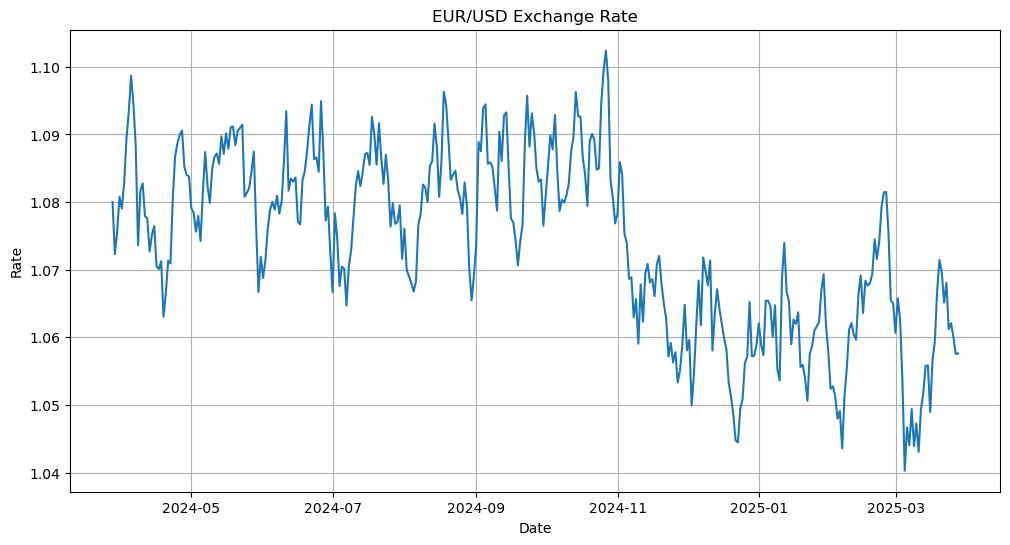

In [3]:
# Query EUR/USD data
eurusd_df = pd.read_sql_query(
    "SELECT date, close FROM fx_rates WHERE pair='EUR/USD' ORDER BY date", 
    conn
)

# Convert date column to datetime
eurusd_df['date'] = pd.to_datetime(eurusd_df['date'])

# Plot the exchange rate
plt.figure(figsize=(12, 6))
plt.plot(eurusd_df['date'], eurusd_df['close'])
plt.title('EUR/USD Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.grid(True)
plt.show()

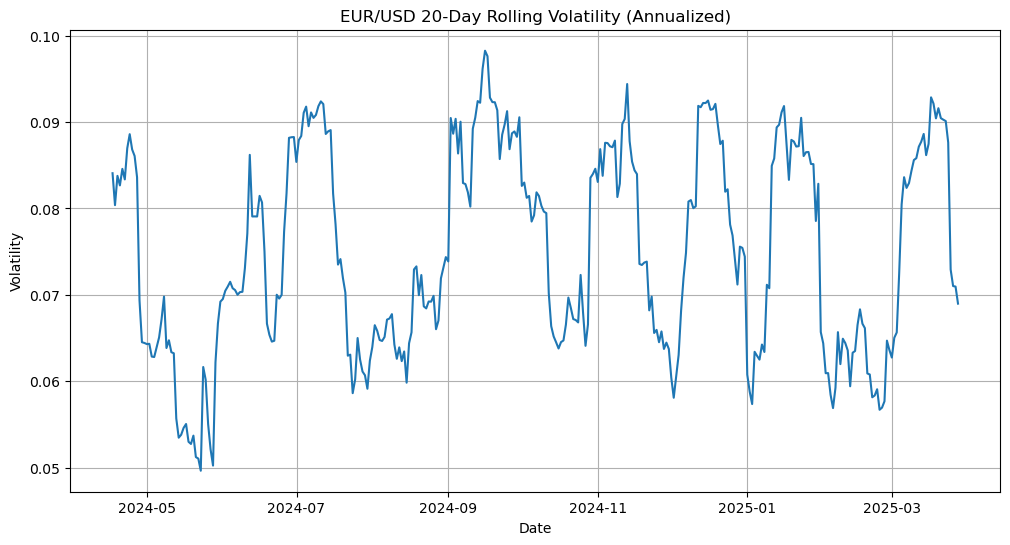

In [4]:
# Calculate daily returns
eurusd_df['return'] = eurusd_df['close'].pct_change()

# Calculate volatility (20-day rolling standard deviation)
eurusd_df['volatility'] = eurusd_df['return'].rolling(window=20).std() * np.sqrt(252)  # Annualized

# Plot volatility
plt.figure(figsize=(12, 6))
plt.plot(eurusd_df['date'][20:], eurusd_df['volatility'][20:])
plt.title('EUR/USD 20-Day Rolling Volatility (Annualized)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(True)
plt.show()

In [5]:
# Get data for multiple currency pairs
pairs = ['EUR/USD', 'GBP/USD', 'USD/JPY', 'AUD/USD']
correlation_data = {}

for pair in pairs:
    query = f"SELECT date, close FROM fx_rates WHERE pair='{pair}' ORDER BY date"
    pair_df = pd.read_sql_query(query, conn)
    pair_df['date'] = pd.to_datetime(pair_df['date'])
    correlation_data[pair] = pair_df.set_index('date')['close']

# Create a DataFrame with all pairs
correlation_df = pd.DataFrame(correlation_data)

# Calculate correlation matrix based on daily returns
correlation_matrix = correlation_df.pct_change().corr()

# Display the correlation matrix
display(correlation_matrix)

,EUR/USD,GBP/USD,USD/JPY,AUD/USD
EUR/USD,1.000000,0.093859,-0.007528,-0.089959
GBP/USD,0.093859,1.000000,0.009632,-0.009807
USD/JPY,-0.007528,0.009632,1.000000,0.109051
AUD/USD,-0.089959,-0.009807,0.109051,1.000000


In [9]:
!pip install pyperclip

  Preparing metadata (setup.py) ... done
  Created wheel for pyperclip: filename=pyperclip-1.9.0-py3-none-any.whl size=11049 sha256=93de0a99a6ab4af5c4cfee9875d458075d3fd05d77f1680535ff764a23cbccd0
  Stored in directory: /home/whiterabbit/.cache/pip/wheels/cc/ae/36/ee17d1de094fcb61e24106cb329b5103861e819f94bef5e10a
Successfully built pyperclip


In [10]:
!pip install nbformat

In [14]:
import pyperclip
import nbformat

# Load the notebook file
with open('FX_Analysis.ipynb', 'r', encoding='utf-8') as f:
    notebook_content = nbformat.read(f, as_version=4)

# Extract code and output content
notebook_text = ""
for cell in notebook_content['cells']:
    if cell['cell_type'] == 'code':
        # Add the code content
        notebook_text += f"Code:\n{cell['source']}\n"
        
        # Check if the cell has outputs
        if 'outputs' in cell:
            for output in cell['outputs']:
                # Ensure the 'data' attribute exists before accessing it
                if 'data' in output:
                    # Handle text/plain output
                    if 'text/plain' in output.data:
                        notebook_text += f"Output (text/plain):\n{output.data['text/plain']}\n"
                    
                    # Handle text/html output
                    elif 'text/html' in output.data:
                        notebook_text += f"HTML Output:\n{output.data['text/html']}\n"
                    
                    # Handle image/png output
                    elif 'image/png' in output.data:
                        notebook_text += f"Image Output (PNG): Image data found.\n"
                    
                    # Add additional output types as needed
                    # Handle other types like LaTeX, JSON, etc.
                    elif 'application/json' in output.data:
                        notebook_text += f"JSON Output: {output.data['application/json']}\n"
                else:
                    notebook_text += "No data found in this output.\n"

# Copy the extracted content to the clipboard
pyperclip.copy(notebook_text)
print("Notebook content copied to clipboard.")


Notebook content copied to clipboard.


In [16]:
!pip install seaborn

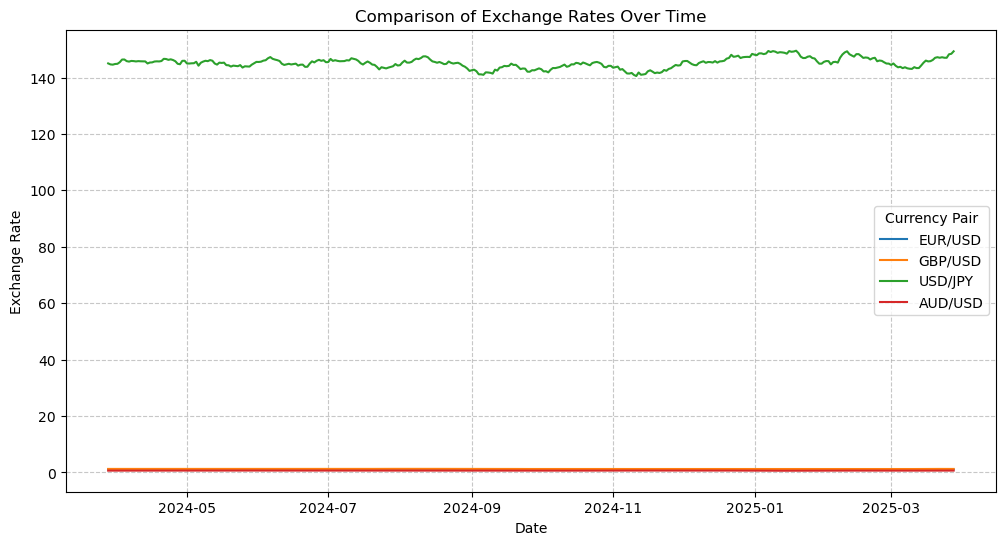

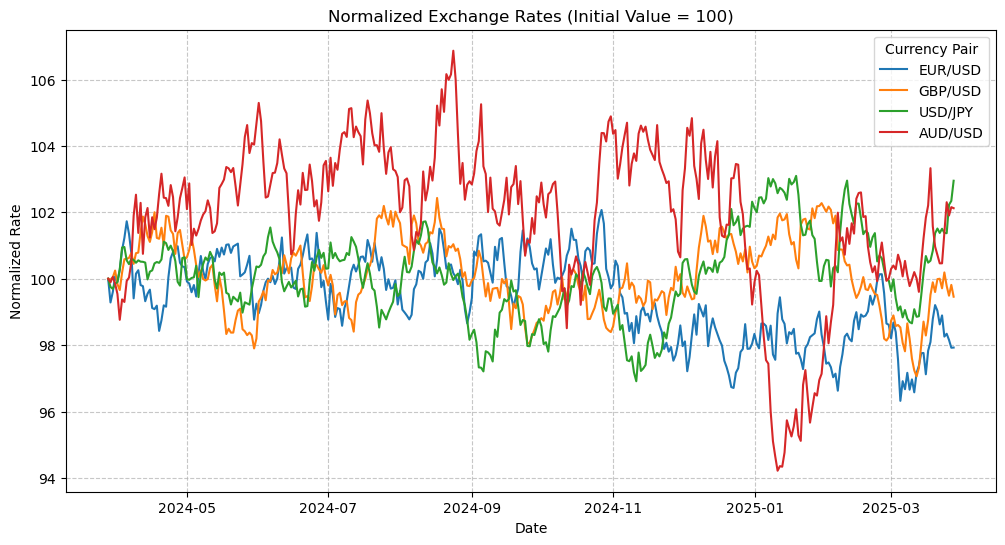

In [18]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a fresh connection to the database
conn = sqlite3.connect('fx_trading.db')

# Get all data for all currency pairs (not just 5 rows)
fx_data = pd.read_sql_query(
    "SELECT date, pair, close FROM fx_rates WHERE pair IN ('EUR/USD', 'GBP/USD', 'USD/JPY', 'AUD/USD')", 
    conn
)

# Convert date column to datetime
fx_data['date'] = pd.to_datetime(fx_data['date'])

# Create a pivot table with pairs as columns
fx_pivoted = fx_data.pivot_table(index='date', columns='pair', values='close')

# Reset the index to make date a column again and melt to long format
fx_melted = fx_pivoted.reset_index().melt(
    id_vars=['date'],
    value_vars=['EUR/USD', 'GBP/USD', 'USD/JPY', 'AUD/USD'],
    var_name='currency_pair',
    value_name='exchange_rate'
)

# Plot the data
plt.figure(figsize=(12, 6))
sns.lineplot(data=fx_melted, x='date', y='exchange_rate', hue='currency_pair')
plt.title('Comparison of Exchange Rates Over Time')
plt.ylabel('Exchange Rate')
plt.xlabel('Date')
plt.legend(title='Currency Pair')
plt.grid(True, linestyle='--', alpha=0.7)

# Optional: Normalize the values for better comparison (since JPY has very different scale)
# Create a separate figure for normalized values
plt.figure(figsize=(12, 6))

# Create normalized version of the data
norm_data = fx_melted.copy()
for pair in fx_melted['currency_pair'].unique():
    pair_data = norm_data[norm_data['currency_pair'] == pair]
    first_value = pair_data['exchange_rate'].iloc[0]
    norm_data.loc[norm_data['currency_pair'] == pair, 'normalized_rate'] = \
        norm_data.loc[norm_data['currency_pair'] == pair, 'exchange_rate'] / first_value * 100

# Plot normalized data
sns.lineplot(data=norm_data, x='date', y='normalized_rate', hue='currency_pair')
plt.title('Normalized Exchange Rates (Initial Value = 100)')
plt.ylabel('Normalized Rate')
plt.xlabel('Date')
plt.legend(title='Currency Pair')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

# Close the connection
conn.close()